In [67]:
# pip install matplotlib
# pip install scikit-image


In [73]:
import numpy as np
import torch
import torchvision
# import cv2
import base64
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import torch.nn as nn
import random
import matplotlib.image as mpimg
from skimage.transform import resize


(56, 56, 1)


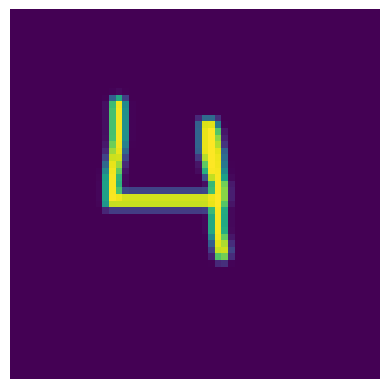

In [72]:
# image_path = "theera_image.png"
# image = mpimg.imread(image_path)
# image = resize(image,(56,56,1))
# print(image.shape)
# # Step 3: Plot the image using plt.imshow
# plt.imshow(image)
# plt.axis("off")  # Optionally turn off axis labels
# plt.show()

In [5]:
# Set seeds for reproducibility
seed_value = 42

# Set PyTorch seed
torch.manual_seed(seed_value)

# Set NumPy seed
np.random.seed(seed_value)
random.seed(seed_value)

# If using CUDA (GPU), set the following flag
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable benchmark mode for deterministic results
torch.cuda.manual_seed_all(seed_value)

In [6]:

class mnist_dataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        self.grid_size = 56
        self.num_classes = 10
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self,index):
        grid_labels = torch.zeros((5+self.num_classes)) 
        class_rank_start = 5 #the first 5 are reserved for object_found_probability and bounding box coordinates
        image, label = self.original_dataset[index]
        grid_labels[class_rank_start+label] = 1
        image = self.inject_matrix(image)
        box_center_h, box_center_w, box_h, box_w = self.coordinates_calculation_relative_2_image(image)
        grid_image, grid_labels = self.labels_per_grid(image,box_center_h, box_center_w, box_h, box_w, grid_labels)
        grid_image = grid_image[np.newaxis,:]
        return grid_image, grid_labels

    def inject_matrix(self,smaller_tensor):
        # Get the shape of the matrices
        # Create a larger tensor of size (200, 700) filled with zeros
        larger_tensor = np.zeros((56,56), dtype=np.float32)

        # target_size = (150, 150)
        # smaller_tensor = smaller_tensor.unsqueeze(0)
        # # Use torch.nn.functional.interpolate to resize the tensor
        # smaller_tensor = F.interpolate(smaller_tensor, size=target_size, mode='bilinear', align_corners=False)
        smaller_tensor = smaller_tensor.squeeze()
        # Get the dimensions of the smaller tensor
        smaller_rows, smaller_cols = smaller_tensor.shape
        
        # Generate random starting coordinates within the valid range
        row_start = np.random.randint(0, larger_tensor.shape[0] - smaller_rows + 1)
        col_start = np.random.randint(0, larger_tensor.shape[1] - smaller_cols + 1)
        
        # Inject the smaller tensor into the larger tensor at the random location
        larger_tensor[row_start:row_start + smaller_rows, col_start:col_start + smaller_cols] = smaller_tensor
        return larger_tensor[np.newaxis,:]
    
    def coordinates_calculation_relative_2_image(self,image):
        h_min = np.Inf
        h_max = -1
        w_min = np.Inf
        w_max = -1
        h_image = image.shape[1]
        w_image = image.shape[2]
        min_found = 0
        for i_h in range(h_image):
            for i_w in range(w_image):
                if image[:,i_h,i_w] != 0:
                    if h_min > i_h:
                        h_min = i_h
                    if w_min > i_w:
                        w_min = i_w
                    if h_min > -1 and i_h > h_max:
                        h_max = i_h
                    if w_min > -1 and i_w > w_max:
                        w_max = i_w
        box_h = h_max - h_min
        box_w = w_max - w_min
        box_center_h = h_min + 0.5*box_h
        box_center_w = w_min + 0.5*box_w
        return box_center_h, box_center_w, box_h, box_w
    
    def labels_per_grid(self,image,box_center_h, box_center_w, box_h, box_w, grid_labels):
        num_of_grids = image.shape[1]//self.grid_size
        for i_grid in range(num_of_grids):
            grid_start = i_grid * self.grid_size
            grid_end = (i_grid+1) * self.grid_size
            grid_image = image[0,grid_start:grid_end,grid_start:grid_end]
            grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w = self.coordinates_calculation_relative_2_grid(grid_image,box_center_h, box_center_w, box_h, box_w)
            grid_labels[1:5] = torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w]) 
        if box_center_h > grid_start and box_center_w > grid_start and box_center_h < grid_end and box_center_w < grid_end:
            grid_labels[0] = 1
        return grid_image, grid_labels #torch.tensor([grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w])
            
    
    def coordinates_calculation_relative_2_grid(self, grid_image,box_center_h, box_center_w, box_h, box_w):
        grid_box_center_h = box_center_h/self.grid_size
        grid_box_center_w = box_center_w/self.grid_size
        grid_box_h = box_h / self.grid_size
        grid_box_w = box_w / self.grid_size
        return grid_box_center_h, grid_box_center_w, grid_box_h, grid_box_w
        
        

    






In [7]:
class MyCnn(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.conv2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Dropout2d(p=0.1)
    )
    self.linear_relu_stack = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=147456, out_features=128),
      torch.nn.ReLU(),
      torch.nn.Dropout(p=0.1),
      torch.nn.Linear(in_features=128, out_features=15),
      torch.nn.ReLU()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    logits = self.linear_relu_stack(x)
    return logits

In [8]:
def draw_box(image, box_center_h, box_center_w, box_height, box_width):
    fig, ax = plt.subplots(1)
    box_center_h =np.floor(box_center_h * train_ds.grid_size)
    box_center_w =np.floor(box_center_w*train_ds.grid_size)
    box_height =np.floor(box_height*train_ds.grid_size)
    box_width =np.floor(box_width*train_ds.grid_size)
    y_min = box_center_h - 0.5 * box_height
    x_min = box_center_w - 0.5 * box_width

    # Display the image
    ax.imshow(np.array(image[0,:,:]))
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    return ax

39.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%
2.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%
100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([10, 1, 56, 56])
torch.Size([10, 15])


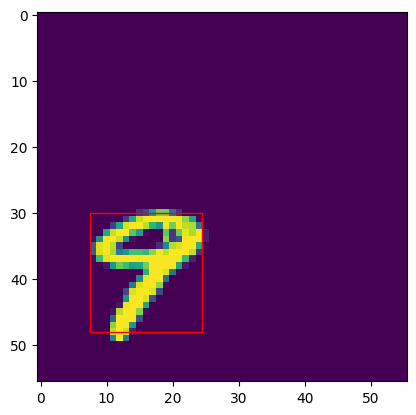

In [9]:
train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)
test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
test_ds = mnist_dataset(test_ds)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10)
i_batch = 9
for batch in test_dl:
    # print(batch[0].squeeze().size())
    # mnist_image = batch[0].squeeze()
    a,b = batch
    print(a.shape)
    print(b.shape)
    draw_box(a[i_batch], b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())
    
    # a = a.unsqueeze(0)
    # a = F.interpolate(a, size=(28,28), mode='bilinear', align_corners=False)
    # plt.figure()
    # plt.imshow(a.squeeze().squeeze())
    break

In [10]:


class YOLOLoss(nn.Module):
    def __init__(self, num_classes=10, lambda_coord=5.0, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

    def forward(self, predictions, targets):
        """
        Calculate YOLO loss.

        Args:
        - predictions: Tensor of shape (batch_size, 15, S, S)
        - targets: Tensor of shape (batch_size, 15, S, S)

        Returns:
        - loss: Scalar tensor representing the total YOLO loss.
        """
        # Extract predicted and target values
        pred_coords = predictions[:, 1:5]
        pred_obj_prob = predictions[:, 0]
        pred_class_probs = predictions[:, 5:]
        # pred_class_probs = nn.functional.softmax(predictions[:, 5:], dim = 1)
        # pred_class_probs = torch.argmax(pred_class_probs, dim = 1)
        
        
        target_coords = targets[:, 1:5]
        target_obj_prob = targets[:, 0]
        target_class_probs = targets[:, 5:]
        # target_class_probs = torch.argmax(target_class_probs, dim = 1)
        
        # Calculate localization loss
        
        loc_loss = torch.sum((pred_coords[:2] - target_coords[:2])**2)
        loc_loss += torch.sum((torch.sqrt(pred_coords[2:]) - torch.sqrt(target_coords[2:]))**2)

        
        # Calculate confidence loss (object present)
        obj_mask = target_obj_prob > 0
        conf_loss_obj = torch.sum((pred_obj_prob[obj_mask] - target_obj_prob[obj_mask])**2)
        
        # Calculate confidence loss (object not present)
        noobj_mask = target_obj_prob == 0
        conf_loss_noobj = torch.sum((pred_obj_prob[noobj_mask])**2)
        
        # Calculate class prediction loss
        class_loss = torch.sum((pred_class_probs - target_class_probs)**2)
        # Combine the individual loss terms
        loss = (
            self.lambda_coord * loc_loss +
            conf_loss_obj +
            self.lambda_noobj * conf_loss_noobj +
            class_loss
        )
        # print(pred_coords)
        # print(target_coords)
        # print(pred_obj_prob)
        # print(target_obj_prob)
        # print(pred_class_probs)
        # print(target_class_probs)
        # print(f'loc_loss = {loc_loss}')
        # print(f'conf_loss_obj = {conf_loss_obj}')
        # print(f'conf_loss_noobj = {conf_loss_noobj}')
        # print(f'class_loss = {class_loss}')
        return loss



In [35]:
def boxes_intersection(box_pred, box_gt):
    x1, y1, h1, w1 = box_pred[:,0],box_pred[:,1],box_pred[:,2],box_pred[:,3]
    x2, y2, h2, w2 = box_gt[:,0],box_gt[:,1],box_gt[:,2],box_gt[:,3]
    # Calculate half-width and half-height for each rectangle
    half_width1, half_height1 = w1 / 2, h1 / 2
    half_width2, half_height2 = w2 / 2, h2 / 2

    # Calculate the coordinates of the top-left and bottom-right corners for each rectangle
    top_left1 = (x1 - half_width1, y1 - half_height1)
    bottom_right1 = (x1 + half_width1, y1 + half_height1)

    top_left2 = (x2 - half_width2, y2 - half_height2)
    bottom_right2 = (x2 + half_width2, y2 + half_height2)

    # Calculate the intersection area
    x_overlap = torch.max(torch.tensor(0), torch.min(bottom_right1[0], bottom_right2[0]) - torch.max(top_left1[0], top_left2[0]))
    y_overlap = torch.max(torch.tensor(0), torch.min(bottom_right1[1], bottom_right2[1]) - torch.max(top_left1[1], top_left2[1]))

    intersection_area = x_overlap * y_overlap

    return intersection_area

def calculate_iou(boxes_pred, boxes_gt):
    box_pred_h, box_pred_w = boxes_pred[:,2], boxes_pred[:,3]
    box_gt_h, box_gt_w = boxes_gt[:,2], boxes_gt[:,3]
    intersection_area = boxes_intersection(boxes_pred, boxes_gt)
    box_pred_area = box_pred_h * box_pred_w
    box_gt_area = box_gt_h * box_gt_w
    union_area = box_pred_area + box_gt_area - intersection_area
    iou = intersection_area / union_area

    return iou.mean()

In [44]:

device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = torchvision.datasets.MNIST(root="data", train=True,  download=True, transform=torchvision.transforms.ToTensor())
train_ds = mnist_dataset(train_ds)


# subset_indices = list(range(1))
# train_ds = Subset(train_ds,subset_indices)


test_ds = torchvision.datasets.MNIST(root="data", train=False,  download=True, transform=torchvision.transforms.ToTensor())
test_ds = mnist_dataset(test_ds)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=False, worker_init_fn=np.random.seed(seed_value))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

myCnn = MyCnn().to(device)
loss = YOLOLoss()
opt = torch.torch.optim.Adam(myCnn.parameters(), lr=1e-3)

for t in range(40):
    for idx, (x, y) in enumerate(train_dl):
      x, y = x.to(device), y.to(device)
      # plt.imshow(x[0,0,:,:].cpu())
      logits = myCnn(x)
      l = loss(logits, y)
      opt.zero_grad()
      l.backward()
      opt.step()
      if idx % 50 == 0: print(f"Epoch: {t}, Loss: {l.item()}")
    with torch.no_grad():
      correct = 0
      total = 0
      iou = 0
      for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        logits = myCnn(x)
        iou += calculate_iou(logits[:,1:5], y[:,1:5])
        class_probabilities = nn.functional.softmax(logits[:,5:], dim=1)
        class_predictions = torch.argmax(class_probabilities,dim=1)
        class_gt = torch.argmax(y[:,5:], dim=1)
        total += y.size(0)
        correct += (class_predictions == class_gt).sum().item()
    iou_mean = iou/total
    print(f"Epoch: {t}, Val_class_accuracy: {correct/total}; box_coordinates_accuracy: {iou_mean.item()}")
    torch.save(myCnn.state_dict(), f"./mnist-{t}.pt")


Epoch: 0, Loss: 2238.362060546875
Epoch: 0, Loss: 288.6283874511719
Epoch: 0, Loss: 260.87286376953125
Epoch: 0, Loss: 244.7198486328125
Epoch: 0, Loss: 241.36990356445312
Epoch: 0, Val_class_accuracy: 0.3074; box_coordinates_accuracy: 0.0017783122602850199
Epoch: 1, Loss: 221.3355712890625
Epoch: 1, Loss: 222.95651245117188
Epoch: 1, Loss: 202.10128784179688
Epoch: 1, Loss: 179.24795532226562
Epoch: 1, Loss: 179.67051696777344
Epoch: 1, Val_class_accuracy: 0.6237; box_coordinates_accuracy: 0.001758983009494841
Epoch: 2, Loss: 174.4009552001953
Epoch: 2, Loss: 167.5382080078125
Epoch: 2, Loss: 134.9356689453125
Epoch: 2, Loss: 120.42902374267578
Epoch: 2, Loss: 127.70503234863281
Epoch: 2, Val_class_accuracy: 0.7987; box_coordinates_accuracy: 0.0019122670637443662
Epoch: 3, Loss: 113.00959777832031
Epoch: 3, Loss: 115.7007827758789
Epoch: 3, Loss: 92.29670715332031
Epoch: 3, Loss: 89.32872772216797
Epoch: 3, Loss: 80.1142349243164
Epoch: 3, Val_class_accuracy: 0.8784; box_coordinates_a

In [45]:
model_path = 'mnist-39.pt'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # Use 'cuda' if you saved the model on GPU

# Step 3: Load the state dictionary into your model
myCnn.load_state_dict(checkpoint)

<All keys matched successfully>

<Axes: >

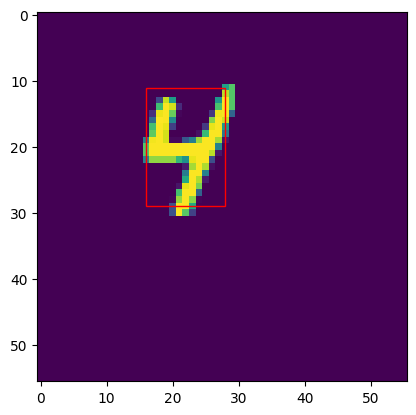

In [46]:
i_batch = 3
b = logits
b.cpu()
images = x
images.cpu()
draw_box(x[i_batch].cpu(), y[i_batch,1].item(),y[i_batch,2].item(),y[i_batch,3].item(),y[i_batch,4].item())


<Axes: >

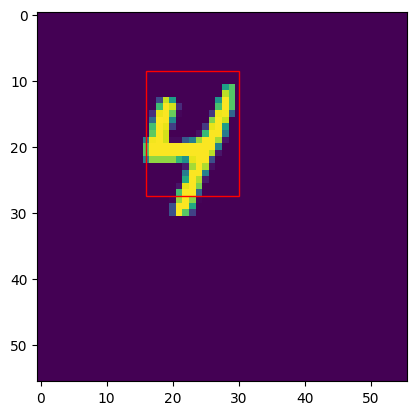

In [47]:
draw_box(images[i_batch].cpu(), b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())

In [48]:
with torch.no_grad():
  correct = 0
  total = 0
  for x, y in test_dl:
    x, y = x.to(device), y.to(device)
    logits = myCnn(x)
    class_prediction = nn.functional.softmax(logits[:,5:], dim=1)
    break

gt class class: 9
predicted class: 9


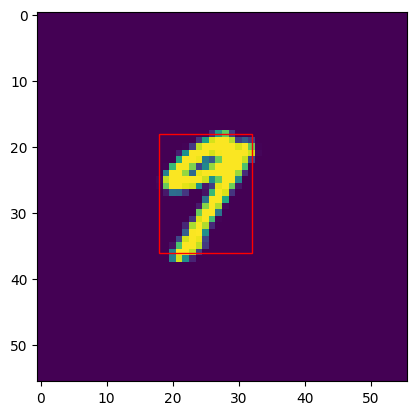

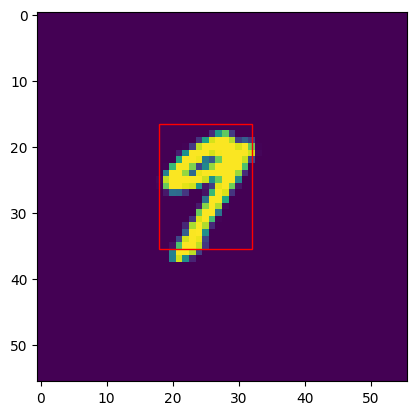

In [50]:
i_batch = 20
print(f'gt class class: {torch.argmax(y[:,5:],dim=1)[i_batch]}')
print(f'predicted class: {torch.argmax(class_prediction,dim=1)[i_batch]}')
ax1 = draw_box(x[i_batch].cpu(), y[i_batch,1].item(),y[i_batch,2].item(),y[i_batch,3].item(),y[i_batch,4].item())
b = logits
b.cpu()
images = x
images.cpu()

ax2 = draw_box(images[i_batch].cpu(), b[i_batch,1].item(),b[i_batch,2].item(),b[i_batch,3].item(),b[i_batch,4].item())
plt.show()

In [285]:
def calculate_accuracy(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
    total_predictions = len(predictions)
    correct_count = count_correct_predictions(predictions, ground_truths, iou_threshold, confidence_threshold)
    accuracy = correct_count / total_predictions if total_predictions > 0 else 0
    return accuracy


def count_correct_predictions(predictions, ground_truths, iou_threshold=0.5, confidence_threshold=0.5):
    correct_count = 0

    for pred in predictions:
        # Apply confidence threshold
        if pred[0] < confidence_threshold:
            continue

        # Find the ground truth with the highest IoU
        max_iou = max([calculate_iou(pred[1:5], gt[1:5]) for gt in ground_truths], default=0)

        # Check if the prediction is correct
        if max_iou >= iou_threshold:
            correct_count += 1

    return correct_count

